<a href="https://colab.research.google.com/github/gil612/PyTorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment
What is model deployment?
Machine Learning model deployment is the act of making your machine learning model(s) available to someone or something else.


## 0. Get Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
  print()
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/gil612/PyTorch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 27.09 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [5]:
import os
import zipfile

from pathlib import Path

import requests



def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """ """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path /destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
      print(f"[INFO] {image_path} directory already exists... skipping download")
    else:
      print(f"[INFO] {image_path} does not exist, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    # Unzip target_file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

    return image_path

In [6]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi does not exist, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Foodvision Mini Model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. 'where is my model going to function?

**FoodVision Mini ideal use case:** A model that perform wellm and fast.

1. Perfoems well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS + or 30ms latency)
  * Latency = time for prediction to take place

To try achive these goals, we're going to buils two midel wxperiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a ceretain problem.

EffNetB2 pretraind model in PyTorch:
--Link--


In [8]:
import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 130MB/s]


In [9]:
from torchinfo import summary
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True))

### 3.1 Creaating a function to make EffNetB2 feature Extractor

In [11]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, seed = 42)

In [13]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
from torchinfo import summary

# summary(effnetb2,
#         input_size=(1, 3, 288, 288),
#         col_names = ["input_size", "output_size", "num_params", "trainable"],
#         col_width = 10,
#         row_settings=['var_names'])

### 3.2 Creating DataLoaders for EffNetB2

In [15]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir= test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32
                                                                                                 )


In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                 train_dataloader=train_dataloader_effnetb2,
                                 test_dataloader=test_dataloader_effnetb2,
                                 epochs=10,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0949 | train_acc: 0.3594 | test_loss: 0.9081 | test_acc: 0.7850
Epoch: 2 | train_loss: 0.8829 | train_acc: 0.7109 | test_loss: 0.8509 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7849 | train_acc: 0.8281 | test_loss: 0.7742 | test_acc: 0.7746
Epoch: 4 | train_loss: 0.7204 | train_acc: 0.7578 | test_loss: 0.6635 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6443 | train_acc: 0.8164 | test_loss: 0.6514 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.5654 | train_acc: 0.9219 | test_loss: 0.5848 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.5171 | train_acc: 0.9336 | test_loss: 0.5634 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.5601 | train_acc: 0.7891 | test_loss: 0.5740 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5473 | train_acc: 0.8125 | test_loss: 0.5411 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.4758 | train_acc: 0.8398 | test_loss: 0.4636 | test_acc: 0.9072


### 3.4 Inspecting EffNetB2 loss curves

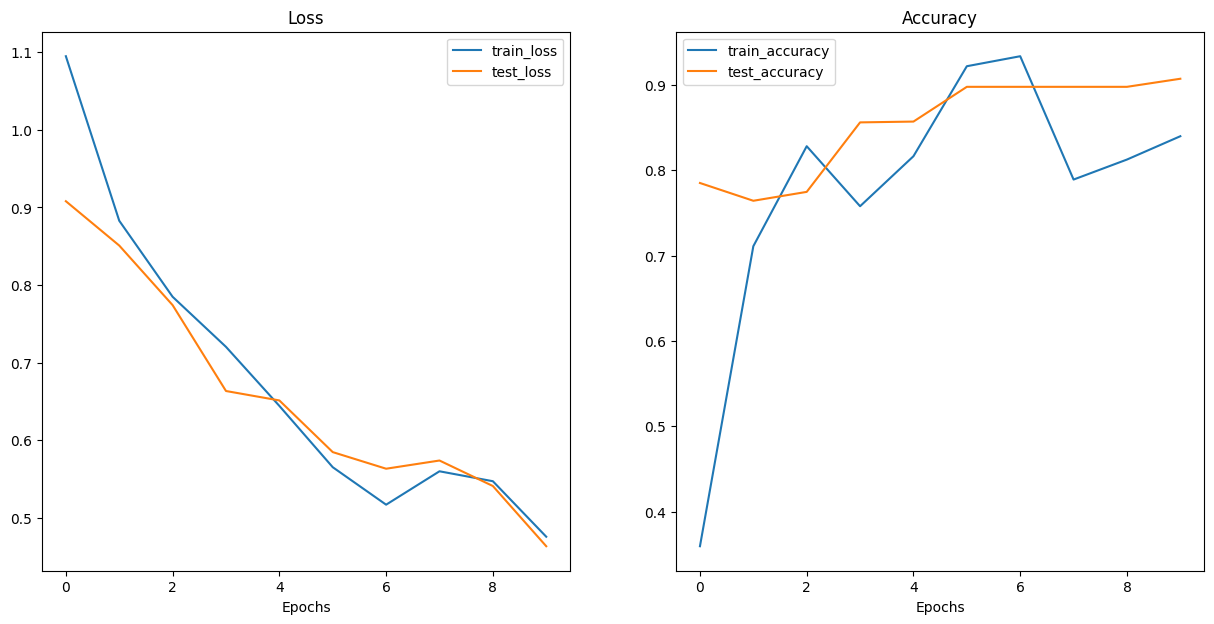

In [18]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [19]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6. Inspecting the size of our EffNetB2 feature extractor

Size of saved model is importnant . There may be limited compute resources. We wouldn't be able to run on our target device.

In [20]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size,2)}MB")

pretrained EffNetB2 feature extractor model size: 29.86MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [21]:
# count numebr of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetB2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parametrs":effnetb2_total_params,
                  "modelsize (MB)" : pretrained_effnetb2_model_size}

In [23]:
effnetB2_stats

{'test_loss': 0.46357306838035583,
 'test_acc': 0.9071969696969697,
 'number_of_parametrs': 7705221,
 'modelsize (MB)': 29.8638858795166}

## 4. Creating ViT feature extractor

In [24]:
# Check out the head layer

vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [25]:
def create_vit_model(num_classes:int=3, seed:int=42):
  # pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

### WARNING : A type spelling of the function requires_grad won't raise an exception
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=num_classes))

  return model, transforms

In [26]:
vit, vit_transforms = create_vit_model(3,42)
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 162MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [27]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [28]:
from torchinfo import summary

# summary(vit,
#         input_size=(1, 3, 224, 224),
#         col_names = ["input_size", "output_size", "num_params", "trainable"],
#         col_width = 10,
#         row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]     768        Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)  False
├─Encoder (encoder)                                          [1, 197, 768] [1, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [1, 197, 768] [1, 197, 768] --         --
│    └─Sequential (layers)                                   [1, 197, 768] [1, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768] [1, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_lay

### 4.1 Create DataLoader for ViT feature extractor

In [29]:
# Setup ViT DataLoader
from going_modular.going_modular import data_setup

# Create a bathc size of 32 (the paper uses 4096 but this may be too big for our sma)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extraxtor

We'reup to model experiment number twoL a ViT feature extractor

In [30]:
from going_modular.going_modular import engine

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training function (engine.py)
set_seeds()
vit_results = engine.train(model=vit,
                                 train_dataloader=train_dataloader_vit,
                                 test_dataloader=test_dataloader_vit,
                                 epochs=10,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 4.3 Plot loss curves on ViT feature extractor

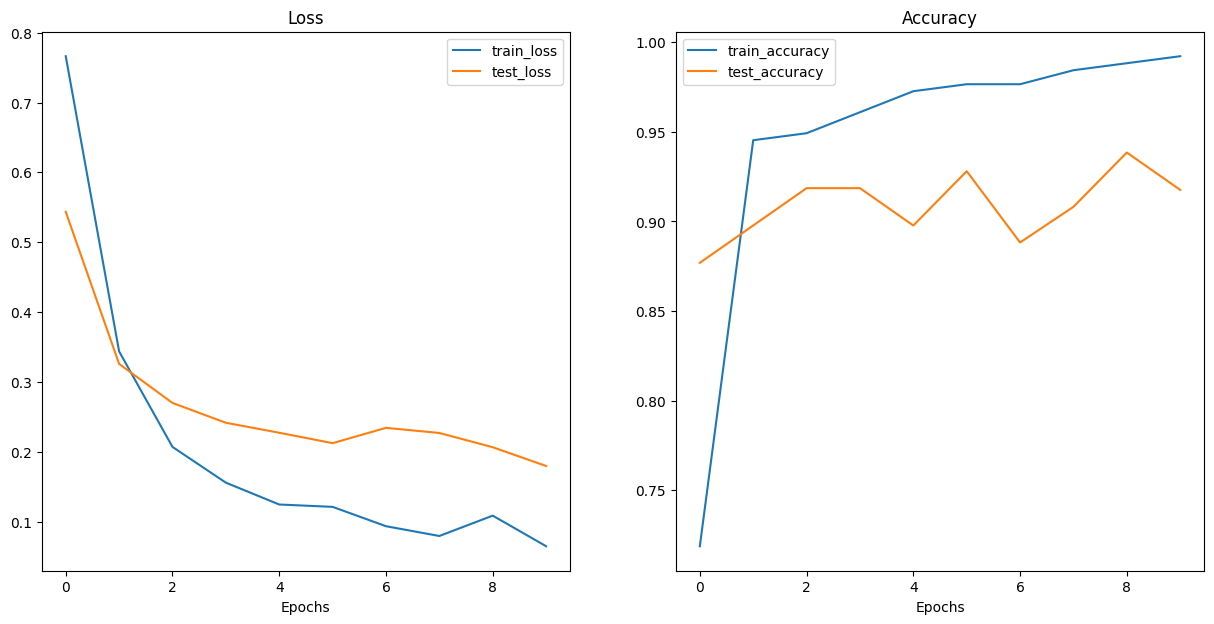

In [31]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [32]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir = "models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [33]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("/content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained ViT feature extractor model size: {round(pretrained_vit_model_size,2)}MB")

pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size,2)}MB")

pretrained ViT feature extractor model size: 327.37MB
pretrained EffNetB2 feature extractor model size: 29.86MB


### 4.6 Collecting ViT feature extractor stats

In [34]:
# count numebr of parameters in vit
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parametrs":vit_total_params,
                  "modelsize (MB)" : pretrained_vit_model_size}

In [36]:
vit_stats, effnetB2_stats

({'test_loss': 0.1795396407445272,
  'test_acc': 0.9176136363636364,
  'number_of_parametrs': 85800963,
  'modelsize (MB)': 327.37096977233887},
 {'test_loss': 0.46357306838035583,
  'test_acc': 0.9071969696969697,
  'number_of_parametrs': 7705221,
  'modelsize (MB)': 29.8638858795166})

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95% + test accuracy)
2. Fast (30+FPS)

to test criteria two:
1. Lop through test images
2. Time how long each model takes to make a prediction on the image
`pred_and store()`

In [37]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg')]

### 5.1 Creating a function to make across the test dataset
1. Create a function that takes a list of paths and a trained PyTorch and a aseries of transforms a list of target class names and a target device.
2. Create an empty list  (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (predictions statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer
7. Open th image using `PIL.Image.open(path)`.
8. Transform the image to be usable path with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn in `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pre prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer startred in step 6 and add the time to the predictions dictionary.
13. See if the predictied class matches the ground truth class.
14. Append the updated predictions dictionary tot he empty list of predictions we created in step 2.
15. Return the list of predictions dictionaries.

In [38]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a aseries of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list  (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (predictions statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_names"] = class_name

    # 6 Start the prediction timer
    start_time = timer()

    # 7 Open th image using `Image.open(path)`.
    img = Image.open(path)

    # 8 Transform the image to be usable path with a given model.
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9 Prepare the model for inference by sending to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10 Turn in torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pre prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim = 1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim = 1) # turn prediction probability into prediciotn label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11 Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12 End the prediction timer startred in step 6 and add the time to the predictions dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13 See if the predictied class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14 Append the updated predictions dictionary tot he empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  # 15 Return the list of predictions dictionaries.
  return pred_list

In [39]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths, model=effnetb2, transform=effnetb2_transforms, class_names=class_names, device = "cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [40]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.8547,
  'pred_class': 'pizza',
  'time_for_pred': 0.4375,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
  'class_names': 'pizza',
  'pred_prob': 0.5366,
  'pred_class': 'sushi',
  'time_for_pred': 0.1868,
  'correct': False}]

In [41]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_names,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/2019408.jpg,pizza,0.8547,pizza,0.4375,True
1,data/pizza_steak_sushi/test/pizza/344397.jpg,pizza,0.5366,sushi,0.1868,False
2,data/pizza_steak_sushi/test/pizza/1503858.jpg,pizza,0.5707,pizza,0.1273,True
3,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.6281,steak,0.1126,False
4,data/pizza_steak_sushi/test/pizza/540882.jpg,pizza,0.5433,pizza,0.1202,True


In [42]:
# Check number of correct predictions
effnetb2_test_pred_df['correct'].value_counts()

,count
correct,
True,68
False,7


In [43]:
# Find the average time for prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average timeper prediction: {effnetb2_average_time_per_pred}")
effnetB2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred

EffNetB2 average timeper prediction: 0.121


> **Note:** Prediciotn times will vary (much like training times) depending on the hardware

In [44]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths, model=vit, transform=vit_transforms, class_names=class_names, device = "cpu")
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df['correct'].value_counts()


  0%|          | 0/75 [00:00<?, ?it/s]

,count
correct,
True,69
False,6


In [45]:
# Find the average time for prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred

ViT average time per prediction: 0.6623


In [46]:
df = pd.DataFrame([effnetB2_stats, vit_stats])
df['model'] = ['EffNetB2', 'ViT']
df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parametrs,modelsize (MB),time_per_pred_cpu,model
0,0.463573,90.72,7705221,29.863886,0.1210,EffNetB2
1,0.179540,91.76,85800963,327.370970,0.6623,ViT


Which model is better?
* `test_loss` - ViT
* `test_acc` - ViT
* `number_of_parametrs` - generally lower is better - EffNetB2
* `modelsize (MB)` EffNetB2
* `time_per_pred_cpu` (lower is better, will be highly dependant in the hardware you're runningn on) - EffNetB2

Both model fail to achieve 30+fps. However we could always just try and us eEffNetB2 and see how it goes

In [47]:
# Compare both models across different characteristics
pd.DataFrame(data=df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"], columns = ['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parametrs,modelsize (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.387295,1.011464,11.135432,10.962102,5.473554


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with speed vs. performance plot.

1. Crete scatter plot
2. Add titles and labels
3. Annotate the samples on the scattere plot so we know what is goiing on.
4. Create a legend based on the model size

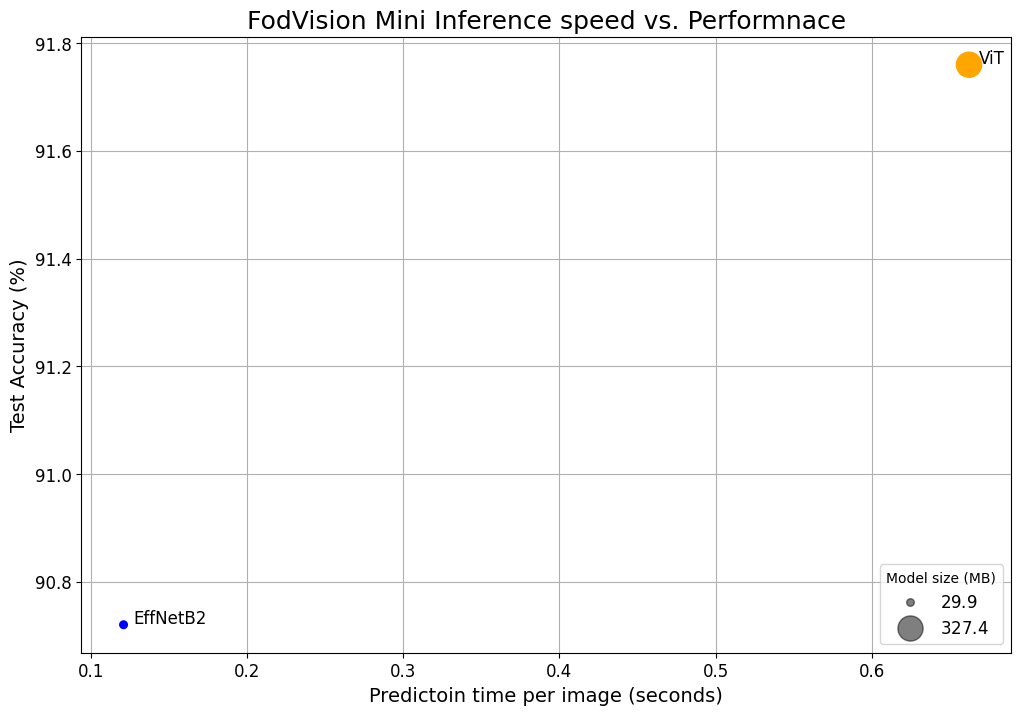

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data = df,
                     x = "time_per_pred_cpu",
                     y="test_acc",
                     c = ["blue", "orange"],
                     s = "modelsize (MB)")

ax.set_title("FodVision Mini Inference speed vs. Performnace", fontsize=18)
ax.set_xlabel("Predictoin time per image (seconds)",  fontsize = 14)
ax.set_ylabel("Test Accuracy (%)",  fontsize = 14)
ax.tick_params(axis="both", labelsize = 12)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"],
             xy=(row["time_per_pred_cpu"] + 0.006 ,row["test_acc"] + 0.003), size=12 )

handles, labels = scatter.legend_elements(prop = "sizes", alpha = 0.5)
nodel_size_legend = ax.legend(handles, labels, loc = "lower right", title = "Model size (MB)", fontsize = 12)

plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deloy EffNetB2 as it fulfils our criteria the best.

What is Gradio?

> Gradio is the fastest way to demo your machime learning model with a friendly web interface so that anyone can use it, anywhere! https://gradio.app/



In [49]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.9 MB/s eta 0:00:00
Gradio version: 5.7.1


### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real world.

Deployment is as important as training

The overall premise of Gradio is to map inputs -> function/model -> outputs

### 7.2 Crating a function to map our inputs and outputs

In [50]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter (effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label)


In [51]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_timer = timer()
  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make predictions
  effnetb2.eval()
  with torch.inference_mode():
  # Pass transformed image through the model an turn the prediction logits into probability
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediciton label and predicition probability dictionary

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred_time
  end_time=timer()
  pred_time =round(end_time - start_timer, 4)

  # Return pred dict and pred time

  return pred_labels_and_probs, pred_time

In [52]:
import random
from PIL import Image

# Get a list of all test image filepaths

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi/test/pizza/2019408.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi/test/sushi/3177743.jpg

{'pizza': 0.11132826656103134, 'steak': 0.12875649333000183, 'sushi': 0.7599152326583862}
0.1017


### 7.3 Creating a list of examples images

The examples for Gradio can be created with `examples` parameter, see here: https://gradio.app/docs/#building-demos

In [53]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi/test/sushi/2741434.jpg'],
 ['data/pizza_steak_sushi/test/pizza/398345.jpg'],
 ['data/pizza_steak_sushi/test/steak/3424937.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface` to go from:

```
input: image -> transform -> predict with EffNetB2 - > output: pred, prob prob, time
```

In [54]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. PyTorch Model Deployment"

# Create the gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time(s)")],
                    examples=example_list,
                    title = title,
                    description=description,
                    article=article)
demo.launch(debug = False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://91cb7d66ccd8434124.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Demo Gradio into a deployable app

Our Gradio demos from gogle Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Huggiing Face Spaces: https://huggingface.co/docs/hub/spaces

### 8.1 What is Hugging Faces spaces?
Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If Github is a place to show your coding ability, Hugging Face Spaces is a place to show your ML ability (through sharing ML demos that you've built).

### 8.2 Deployed Gradio App structure

Lets start to put all of our files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look lke this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this structure?

Because it's one of the simplest we start with.

You can see this in action:
* Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
* example file structure - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [55]:
import shutil # High-level file operations
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that moght exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use our Foodvision Mini demo
* 3 images is an `examples/` directory
* Images should be from the test set

In [56]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                exist_ok=True)

# Collect random test dataset images paths
foodvision_mini_examples = [random.choice(list(Path(f"{test_dir}").glob("*/*.jpg"))) for i in range(3)]


# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst = destination)
  print(destination)
  print(example.name)


[INFO] Copying data/pizza_steak_sushi/test/pizza/309892.jpg to demos/foodvision_mini/examples/309892.jpg
demos/foodvision_mini/examples/309892.jpg
309892.jpg
[INFO] Copying data/pizza_steak_sushi/test/sushi/343036.jpg to demos/foodvision_mini/examples/343036.jpg
demos/foodvision_mini/examples/343036.jpg
343036.jpg
[INFO] Copying data/pizza_steak_sushi/test/steak/502076.jpg to demos/foodvision_mini/examples/502076.jpg
demos/foodvision_mini/examples/502076.jpg
502076.jpg


Let's now verify that we can get a list of lists  from `examples/` directory

In [57]:
import os

#
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/502076.jpg'], ['examples/343036.jpg'], ['examples/309892.jpg']]

In [58]:
foodvision_mini_examples = [random.choice(list(Path(f"{test_dir}").glob("*/*.jpg"))) for i in range(3)]
foodvision_mini_examples

[PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg')]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [59]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  shutil.move(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvision_mini_destination)

# Check if the model has already moved
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_destination}: {effnetb2_foodvision_mini_destination.exists()}")


### 8.6 Turning off EffNetB2 model into a Python script ("model.py")
Let's move our `create_effnetb2_model()` function to a script so we can reuse it

In [60]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [61]:
# %%writefile demos/foodvision_mini/app.py
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [62]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location = torch.device("cpu") # load the model to the cpu
    )
)

### 3. Predict fucntion ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_timer = timer()
  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make predictions
  effnetb2.eval()
  with torch.inference_mode():
  # Pass transformed image through the model an turn the prediction logits into probability
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediciton label and predicition probability dictionary

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred_time
  end_time=timer()
  pred_time =round(end_time - start_timer, 4)

  # Return pred dict and pred time

  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. PyTorch Model Deployment"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time(s)")],
                    examples=example_list,
                    title = title,
                    description=description,
                    article=article)
demo.launch(debug = False)

Writing demos/foodvision_mini/app.py


### 8.6 Turning off EffNetB2 model into a Python script ("model.py")
Let's move our `create_effnetb2_model()` function to a script so we can reuse it

In [63]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

Overwriting demos/foodvision_mini/model.py


In [64]:
# %%writefile demos/foodvision_mini/app.py
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [65]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setip ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location = torch.device("cpu") # load the model to the cpu
    )
)

### 3. Predict fucntion ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_timer = timer()
  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make predictions
  effnetb2.eval()
  with torch.inference_mode():
  # Pass transformed image through the model an turn the prediction logits into probability
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediciton label and predicition probability dictionary

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred_time
  end_time=timer()
  pred_time =round(end_time - start_timer, 4)

  # Return pred dict and pred time

  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi."
article = "Created at 09. PyTorch Model Deployment"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time(s)")],
                    examples=example_list,
                    title = title,
                    description=description,
                    article=article)
demo.launch(debug = False)

Overwriting demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for  FoodVision mini (`requiremnts.txt)

* `torch`
* `torchvision`
* `gradio`

In [66]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.5.0
torchvision==0.20.0
gradio==5.7.1

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

### 9.1 Downloading our FoodVision Minin app files

We want to download our `foodvision_mini` demo app so we can upload it to HuggingFace Spaces.

In [67]:
!ls demos/foodvision_mini/examples

309892.jpg  343036.jpg	502076.jpg


In [68]:
# Change into the Foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/502076.jpg (deflated 0%)
  adding: examples/343036.jpg (deflated 0%)
  adding: examples/309892.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [69]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo locally

### 9.3 Uploading our FoodVision mini Gradio demo to HuggingFace Spaces

In [70]:
from IPython.display import IFrame

IFrame(src="https://gil612-my-space.hf.space", width=900, height=750)

## 10. Creating FoodVision Big!!!

Let's step things up a notch and make FoodVision BIG, using all of the Food101 classes

### 10.1 Creating a model for FoogVision Big + transforms

In [24]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

from torchinfo import summary

# summary(effnetb2_food101,
#         input_size=(1, 3, 224, 224),
#         col_names = ["input_size", "output_size", "num_params", "trainable"],
#         col_width = 20,
#         row_settings=['var_names'])

**More output features in the final layer equals more trainable parameters.**



Since we're working with a with a larger dataset, we may want to introduce some data augmentation techniques:
*  This is becase with largere datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, let's use TrivialAugment as ou data augmentation technique.

First a list of state-of-the-art computer vision recipes:
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [25]:
# Creating training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [26]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

In [27]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split = "train",
                              transform = food101_train_transforms, # apply data augmentation to training data
                              download = True)

# Get the training data (~250 x 101 classes)
test_data = datasets.Food101(root=data_dir,
                              split = "test",
                              transform = effnetb2_transforms, # don't perform ata augmentation on the test data
                              download = True)

100%|██████████| 5.00G/5.00G [03:41<00:00, 22.6MB/s]


Extracting data/food-101.tar.gz to data


In [28]:
# Get Food101 class names
food101_class_names = train_data.classes

### 10.3 Creating a subset of the Food101 dataset for faster experimanting

* 20% of the data

We want to beat the result of 56.4% using modern deep learning techniques and only 20% of the data.

In [29]:
from torch.utils.data import random_split

def split_dataset(dataset=torchvision.datasets,
                  split_size:float=0.5,
                  seed:int=42):
  # Create split lenghts based on original dataset length
  length_1 = int(len(dataset)* split_size)
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting datasets of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1 ,random_split_2 = torch.utils.data.random_split(dataset,
   lengths=[length_1, length_2],
   generator = torch.manual_seed(seed))

  return random_split_1, random_split_2

In [30]:
# Create training 20% split Food101
train_data_food101_50_percent, _ = split_dataset(dataset=train_data, split_size=0.5)

# Create testing 20% split Food101
test_data_food101_50_percent, _ = split_dataset(dataset=test_data, split_size=0.5)

[INFO] Splitting datasets of length 75750 into splits of size: 37875 and 37875
[INFO] Splitting datasets of length 25250 into splits of size: 12625 and 12625


In [32]:
len(train_data_food101_50_percent), len(test_data_food101_50_percent),

(37875, 12625)

### 10.4 Turning our Food101 datasets into `DataLoader`s

In [33]:
import os
os.cpu_count()

2

In [34]:
import torch

NUM_WORKER = 2 # very experimental
BATCH_SIZE = 32

# Create Food101 50 training DataLoader
train_dataloader_food101_50_percent = torch.utils.data.DataLoader(dataset = train_data_food101_50_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle = True,
                                                                  num_workers = NUM_WORKER)

# Create Food101 50 testing DataLoader
test_dataloader_food101_50_percent = torch.utils.data.DataLoader(dataset = test_data_food101_50_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle = False,
                                                                  num_workers = NUM_WORKER)

In [35]:
len(train_dataloader_food101_50_percent), len(test_dataloader_food101_50_percent)

(1184, 395)

In [36]:
train_data_food101_50_percent

In [37]:
train_dataloader_food101_50_percent

###10.5 Trainig FoodVision Big!!!!!

Things for training:
* 5 epochs
* Optimizer: `torch.optim.Adam(lr=1e-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use label smoothing?

Label smoothing helps to prevent overfitiing (it's a regularization technique).

Without label smoothing and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

>**Note:** takes about 35:53 minutes for 10 epochs

In [38]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn=torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                 train_dataloader=train_dataloader_food101_50_percent,
                                 test_dataloader=test_dataloader_food101_50_percent,
                                 epochs=7,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 device = device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2113 | train_acc: 0.3636 | test_loss: 2.3527 | test_acc: 0.5710
Epoch: 2 | train_loss: 2.6901 | train_acc: 0.4684 | test_loss: 2.2108 | test_acc: 0.5954
Epoch: 3 | train_loss: 2.5998 | train_acc: 0.4919 | test_loss: 2.1736 | test_acc: 0.6088
Epoch: 4 | train_loss: 2.5664 | train_acc: 0.5022 | test_loss: 2.1571 | test_acc: 0.6089
Epoch: 5 | train_loss: 2.5411 | train_acc: 0.5101 | test_loss: 2.1375 | test_acc: 0.6174
Epoch: 6 | train_loss: 2.5326 | train_acc: 0.5116 | test_loss: 2.1267 | test_acc: 0.6202
Epoch: 7 | train_loss: 2.5171 | train_acc: 0.5146 | test_loss: 2.1130 | test_acc: 0.6274


### 10.6 Inspecting losscurves of FoodVsion Big model

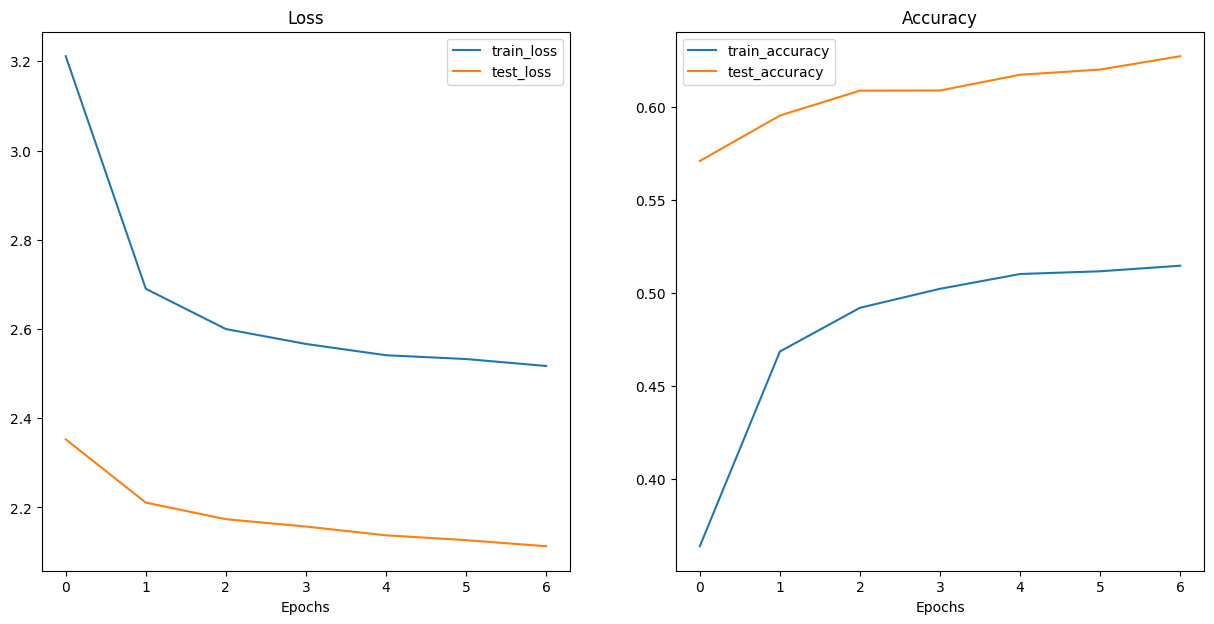

In [39]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision big model

In [40]:
from going_modular.going_modular import utils

effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth"
utils.save_model(model=effnetb2_food101,
                 target_dir = "models/",
                 model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth


In [41]:
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth"))

<ipython-input-41-3faddb220b18>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_ex

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [42]:
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffnetB2 feature extractor Food101 size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffnetB2 feature extractor Food101 size: 30 MB


In [43]:
from torchinfo import summary

# summary(effnetb2_food101,
#         input_size=(1, 3, 224, 224),
#         col_names = ["input_size", "output_size", "num_params", "trainable"],
#         col_width = 20,
#         row_settings=['var_names'])

## 11. Turning our FoodVision Big model into a deployable app

Deploying a model allows you to sww how your model goes in the real_world (the ultimate test set).

In [44]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big")

# Make FoodVision Big demo directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [45]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading an example image and moving it to the `examples` directory

In [46]:
# Download and move an example image
!wget https://raw.githubusercontent.com/gil612/PyTorch/refs/heads/main/01-pizza.jpeg
!mv 01-pizza.jpeg demos/foodvision_big/examples/01-pizza.jpeg

--2024-12-02 23:09:33--  https://raw.githubusercontent.com/gil612/PyTorch/refs/heads/main/01-pizza.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2516966 (2.4M) [image/jpeg]
Saving to: ‘01-pizza.jpeg’

01-pizza.jpeg       100%[===================>]   2.40M  --.-KB/s    in 0.06s   

2024-12-02 23:09:33 (42.7 MB/s) - ‘01-pizza.jpeg’ saved [2516966/2516966]



In [47]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth demos/foodvision_big/

### 11.2 Saving Food101 class names to files(`class_names.txt`)

In [48]:
# Create path to Food101 class namnes
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [49]:
# Write Food101 Class names to text file
with open(foodvision_big_class_names_path, 'w') as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [50]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]
food101_class_names_loaded[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

### 11.3 Turning our Foodvision Big model into a Python script (`model.py`)

In [51]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes) )

  return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our Foodvision Big Gradio app into a Python script (`app.py`)

In [52]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth",
        map_location = torch.device("cpu") # load the model to the cpu
    )
)

### 3. Predict fucntion ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_timer = timer()
  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make predictions
  effnetb2.eval()
  with torch.inference_mode():
  # Pass transformed image through the model an turn the prediction logits into probability
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediciton label and predicition probability dictionary

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred_time
  end_time=timer()
  pred_time =round(end_time - start_timer, 4)

  # Return pred dict and pred time

  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision BIG"
description = "An EfficientNetB2 feature extractor computer vision model to classify images 101 classes of food from the Food101 dataset."
article = "Created at 09. PyTorch Model Deployment"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time(s)")],
                    examples=example_list,
                    title = title,
                    description=description,
                    article=article)
demo.launch(debug = False)

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Bif (`requirements`)

In [53]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.5.0
torchvision==0.20.0
gradio==5.7.1

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [54]:
# Change into the Foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_50_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/01-pizza.jpeg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [55]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
### 11.7 deploying our Foodvision Bog Model app to HuggingFace Spaces